In [1]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import DQN
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print("GPU Available:", torch.cuda.is_available())



GPU Available: True


In [ ]:
# Loading predicted dataset
df_bit = pd.read_excel("Bit_new.xlsx").iloc[:-1]
train_bit_1 = df_bit["Predicted Value (1)"].to_numpy()
train_bit_ts = pd.read_csv('bchain_forecast_output.csv').iloc[:,1].to_numpy()
test_bit = df_bit["Value"].to_numpy()

df_gold = pd.read_excel("Gold_new.xlsx").iloc[:-1]
train_gold_1 = df_gold["Predicted Value (1)"].to_numpy()
train_gold_ts = pd.read_csv('gold_forecast_output.csv').iloc[:,1]
train_gold_ts = train_gold_ts.drop_duplicates(keep='first')[:-1].to_numpy()
test_gold = df_gold["USD (PM)"].to_numpy()

bit_ori = pd.read_csv("BCHAIN-MKPRU.csv")
gold_ori = pd.read_csv("LBMA-GOLD.csv")
train_bit_ori = bit_ori["Value"].to_numpy()
train_gold_ori = gold_ori["USD (PM)"].to_numpy()

train_bit = [train_bit_1, train_bit_ts, train_bit_ori]
train_gold = [train_gold_1, train_gold_ts, train_gold_ori]



In [ ]:
# Trading environment for agent
class TradingEnv(gym.Env):
    def __init__(self, data, seed, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.seed_value = seed
        self.portfolio = []
        self.seed(seed)

        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, np.min(data)]),
            high=np.array([np.inf, np.inf, np.max(data)]),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)

        # Metrics for visualization
        self.price_history = []
        self.balance_history = []
        self.holdings_history = []
        self.action_history = []

        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)
        random.seed(seed)
        
    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.current_step = 0
        self.done = False
        self.portfolio = []

        # Reset histories
        self.price_history = [self.data[self.current_step]]
        self.balance_history = [self.balance]
        self.holdings_history = [self.holdings]
        self.action_history = []

        return self._get_state()

    def _get_state(self):
        return np.array([self.balance, self.holdings, self.data[self.current_step]])

    def step(self, action):
        current_price = self.data[self.current_step]
        next_price = self.data[self.current_step + 1]

        portfolio_value_before = self.balance + self.holdings * current_price
        reward = 0
        
        # After experimenting hundreds, if not thousands of time, the best buying and selling proportion found is 0.3 and 0.6
        if action == 1:  # Buy
            amount_to_buy = (self.balance * 0.3) / current_price
            self.holdings += amount_to_buy
            self.balance -= amount_to_buy * current_price
        elif action == 2:  # Sell
            amount_to_sell = self.holdings * 0.6
            self.holdings -= amount_to_sell
            self.balance += amount_to_sell * current_price

        portfolio_value_after = self.balance + self.holdings * next_price
        portfolio_update = portfolio_value_after - portfolio_value_before
        reward += portfolio_update
        self.portfolio.append(portfolio_update)

        # Update histories
        self.current_step += 1
        self.price_history.append(next_price)
        self.balance_history.append(self.balance)
        self.holdings_history.append(self.holdings)
        self.action_history.append(action)

        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def render(self):
        steps = range(len(self.price_history))

        plt.figure(figsize=(12, 8))

        # Plot price trend
        plt.plot(steps, self.price_history, label='Price', color='blue', linewidth=2)
        plt.fill_between(steps, 0, self.price_history, color='blue', alpha=0.1)

        # Plot balance
        plt.plot(steps, self.balance_history, label='Balance', color='green', linestyle='--')

        # Plot holdings
        holdings_value = np.array(self.holdings_history) * np.array(self.price_history)
        plt.plot(steps, holdings_value, label='Holdings Value', color='orange', linestyle='-.')

        # Annotate actions
        label_buy, label_sell = True, True
        for step, action in enumerate(self.action_history):
            if action == 1: # Buy
                if label_buy:
                    plt.scatter(step, self.price_history[step], label="Buy", color='green', marker='^')
                    label_buy = False
                else:
                    plt.scatter(step, self.price_history[step], color='green', marker='^')
            elif action == 2: # Sell
                if label_sell:
                    plt.scatter(step, self.price_history[step], label="Sell", color='red', marker='v')
                    label_sell = False
                else:
                    plt.scatter(step, self.price_history[step], color='red', marker='v')
            

        plt.title('Trading Performance')
        plt.xlabel('Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
# Training agent for trading
def set_global_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def RL_training(train, test, seed):
    # Train RL agent
    env_train = TradingEnv(train, seed)
    model = DQN("MlpPolicy", env_train, verbose=1, seed=seed, device='cuda') # Learning rate 0.0001, batch size 32
    model.learn(total_timesteps=10000)
    
    # Evaluate on test data
    env_test = TradingEnv(test, seed)
    earnings = []
    n_experiment = 100

    for _ in range(n_experiment):
        state = env_test.reset()  # Reset the test environment
        done = False
        while not done:
            action, _ = model.predict(state)  # Use the trained model
            state, reward, done, _ = env_test.step(action)  # Step through the test environment
        earnings.append(sum(env_test.portfolio))

    return np.mean(earnings), env_test

In [6]:
# Other Benchmark Trading Strategy
def buy_hold(true_price, predicted_price, initial_balance=10000):
    amount = initial_balance/true_price[0]
    balance = amount * true_price[-1]
    return balance - initial_balance


def buy_sell(true_price, predicted_price, initial_balance=10000):
    balance = initial_balance
    able_to_buy, able_to_sell = True, False
    for i in range(len(predicted_price)-1):
        if predicted_price[i+1] > predicted_price[i] and able_to_buy:
            amount = balance / true_price[i]
            balance = 0
            able_to_buy, able_to_sell = False, True
        elif predicted_price[i+1] < predicted_price[i] and able_to_sell:
            balance += amount * true_price[i]
            amount = 0
            able_to_buy, able_to_sell = True, False
    balance += amount * true_price[-1]
    return balance - initial_balance


def cross_strategy(ori_price, predicted_price, initial_balance=10000):
    r, u = 1.05, 0.05
    amount = 0
    balance = initial_balance
    for i in range(len(predicted_price)):
        day5_change = (predicted_price[i] - ori_price[i-32-5])/5
        # print(day5_change)
        day20_change = (predicted_price[i] - ori_price[i-32-20])/20
        # print(day20_change)
        if day5_change > 0 and day20_change > 0:
            if day5_change >= r * day20_change:
                if balance > u * ori_price[i-32]:
                    amount += u
                    balance -= u * ori_price[i-32]
                else:
                    amount += balance / ori_price[i-32]
                    balance -= amount * ori_price[i-32]
        elif day5_change < 0 and day20_change < 0:
            if day20_change < r * day5_change:
                if amount > u:
                    amount -= u
                    balance += u * ori_price[i-32]
                else:
                    balance += amount * ori_price[i-32]
                    amount -= amount
    if amount > 0:
        balance += amount * ori_price[-1]
    return balance - initial_balance


def vma(ori_price, predicted_price, initial_balance=10000):
    amount, balance = 0, initial_balance
    u = 0.05
    for i in range(len(predicted_price)):
        lma = np.mean(np.log(ori_price[i-32-50:i-32]))
        sma = np.log(predicted_price[i])
        # print(lma, sma)
        if sma > lma:
            if balance > u * ori_price[i-32]:
                amount += u
                balance -= u * ori_price[i-32]
            else:
                amount += balance / ori_price[i-32]
                balance -= balance
    balance += amount * ori_price[-1]
    return balance - initial_balance

In [66]:
# Visualize the trading result
def trading_strategy_result(train, test, rl_result):
    table = pd.DataFrame({
        "RL Model" : rl_result, 
        "Buy/Hold Method" : [buy_hold(test, t) for t in train[:-1]],
        "Buy/Sell Method" : [buy_sell(test, t) for t in train[:-1]],
        "Cross Strategy" : [cross_strategy(train[-1], t) for t in train[:-1]], 
        "VMA Oscillator" : [vma(train[-1], t) for t in train[:-1]]},
        index=['LSTM', "SARIMA"])
    return table

# Visualize the trading operation by agent
def render(env_history):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(9, 8))
    for i, ax in enumerate(axes):
        price_history, balance_history, holdings_history, action_history = env_history[i]
        steps = range(len(price_history))

        # Plot price trend
        ax.plot(steps, price_history, label='Price', color='blue', linewidth=2)
        ax.fill_between(steps, 0, price_history, color='blue', alpha=0.1)

        # Plot balance
        ax.plot(steps, balance_history, label='Balance', color='green', linestyle='--')

        # Plot holdings
        holdings_value = np.array(holdings_history) * np.array(price_history)
        ax.plot(steps, holdings_value, label='Holdings Value', color='orange', linestyle='-.')

        # Annotate actions
        label_buy, label_sell = True, True
        for step, action in enumerate(action_history):
            if action == 1: # Buy
                if label_buy:
                    ax.scatter(step, price_history[step], label="Buy", color='green', marker='^')
                    label_buy = False
                else:
                    ax.scatter(step, price_history[step], color='green', marker='^')
            elif action == 2: # Sell
                if label_sell:
                    ax.scatter(step, price_history[step], label="Sell", color='red', marker='v')
                    label_sell = False
                else:
                    ax.scatter(step, price_history[step], color='red', marker='v')
        ax.set_title(f'Trading Performance ({['LSTM', "SARIMA"][i]})')
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# Start executing the Program (After executing all codes above, the whole program starts here.)

seed = 19
set_global_seeds(seed)

rl_bit = []
env_history_bit = []
for i, train in enumerate(train_bit[:-1]):
    earning, env_test = RL_training(train, test_bit, seed)
    rl_bit.append(earning)
    env_history_bit.append([env_test.price_history, env_test.balance_history, \
                            env_test.holdings_history, env_test.action_history])

rl_gold = []
env_history_gold = []
for i, train in enumerate(train_gold[:-1]):
    earning, env_test = RL_training(train, test_gold, seed)
    rl_gold.append(earning)
    env_history_gold.append([env_test.price_history, env_test.balance_history, \
                            env_test.holdings_history, env_test.action_history])





Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6216     |
|    time_elapsed     | 0        |
|    total_timesteps  | 120      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46e+03 |
|    n_updates        | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 14.3     |
|    exploration_rate | 0.772    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2862     |
|    time_elapsed     | 0        |
|    total_timesteps  | 240      |
| train/              |       

c:\Users\linxi\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 152      |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 1550     |
|    time_elapsed     | 0        |
|    total_timesteps  | 480      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 174      |
|    n_updates        | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30       |
|    ep_rew_mean      | 165      |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 1405     |
|    time_elapsed     | 0        |
|    total_timesteps  | 600      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 157      |
|    n_updates      

In [48]:
trading_strategy_result(train_bit, test_bit, rl_bit)

,RL Model,Buy/Hold Method,Buy/Sell Method,Cross Strategy,VMA Oscillator
LSTM,172.194241,-55.053087,-1125.641663,-7070.230912,147.570646
SARIMA,86.325411,-55.053087,4463.770981,-8038.855809,147.570646


In [49]:
trading_strategy_result(train_gold, test_gold, rl_gold)

,RL Model,Buy/Hold Method,Buy/Sell Method,Cross Strategy,VMA Oscillator
LSTM,5.939575,376.592103,293.550253,1.195,3.5550
SARIMA,6.260357,376.592103,806.069576,0.900,1.1575


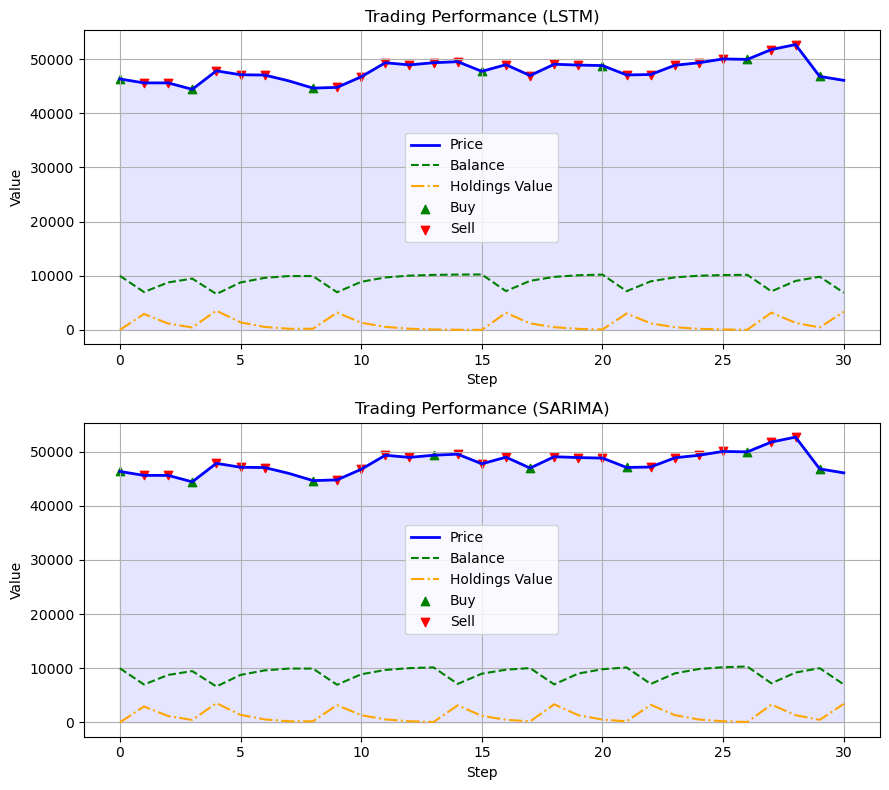

In [67]:
render(env_history_bit)

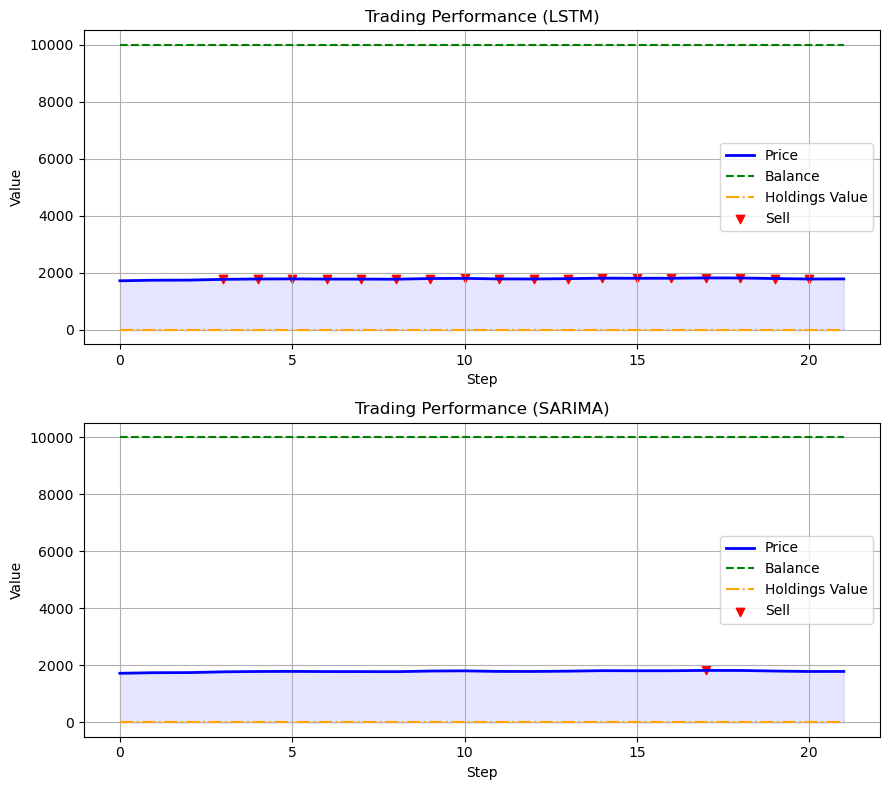

In [68]:
render(env_history_gold)